In [25]:
import os 

import numpy as np 
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import nbimporter
import Useful_Visualization_Functions
from pyspark.sql.types import *
warnings.filterwarnings("ignore")

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.functions import lit, col, column, expr, desc, asc

In [4]:
# ! pip install matplotlib
# ! pip install seaborn
# ! pip install ipynb
# ! pip install nbimporter

In [5]:
# build our own SparkSession
myspark = SparkSession\
    .builder\
    .appName("AWS-Spark")\
    .config("spark.driver.memory", "15g") \
    .config("spark.sql.shuffle.partitions",6)\
    .config("spark.sql.repl.eagereval.enabled",True)\
    .getOrCreate()

22/05/17 11:58:09 WARN Utils: Your hostname, nuno-g14 resolves to a loopback address: 127.0.1.1; using 192.168.1.225 instead (on interface wlp2s0)
22/05/17 11:58:09 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/17 11:58:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/05/17 11:58:11 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [6]:
myspark

In [7]:
# ! head noaa.csv
# noaa_data.show(10)
noaa_data = myspark.read.load("noaa.csv", format="csv", sep=",", header=True, inferSchema=True)
noaa_data.count()

22601

In [8]:
# noaa_data.show(10)

In [9]:
# temp_filt = (noaa_data.filter(noaa_data.ELEVATION <= 5))
# temp_filt.count()

In [10]:
#latitude_order = noaa_data.orderBy("LATITUDE", ascending=False)
#latitude_order.show(10)

In [11]:
noaa_data.printSchema()

root
 |-- STATION: integer (nullable = true)
 |-- DATE: string (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- LONGITUDE: double (nullable = true)
 |-- ELEVATION: double (nullable = true)
 |-- NAME: string (nullable = true)
 |-- TEMP: double (nullable = true)
 |-- TEMP_ATTRIBUTES: double (nullable = true)
 |-- DEWP: double (nullable = true)
 |-- DEWP_ATTRIBUTES: double (nullable = true)
 |-- SLP: double (nullable = true)
 |-- SLP_ATTRIBUTES: double (nullable = true)
 |-- STP: double (nullable = true)
 |-- STP_ATTRIBUTES: double (nullable = true)
 |-- VISIB: double (nullable = true)
 |-- VISIB_ATTRIBUTES: double (nullable = true)
 |-- WDSP: double (nullable = true)
 |-- WDSP_ATTRIBUTES: double (nullable = true)
 |-- MXSPD: double (nullable = true)
 |-- GUST: double (nullable = true)
 |-- MAX: double (nullable = true)
 |-- MAX_ATTRIBUTES: string (nullable = true)
 |-- MIN: double (nullable = true)
 |-- MIN_ATTRIBUTES: string (nullable = true)
 |-- PRCP: double (nullable = 

In [12]:
noaa_data.select("TEMP", "ELEVATION", "VISIB").show(10)

+----+---------+-----+
|TEMP|ELEVATION|VISIB|
+----+---------+-----+
|23.4|      9.0| 28.0|
|31.5|      9.0|  4.9|
|35.0|      9.0|  3.1|
|35.4|      9.0|  6.1|
|27.5|      9.0| 13.5|
|23.6|      9.0|  8.6|
|18.7|      9.0|  4.1|
|26.9|      9.0|999.9|
|31.7|      9.0|  5.9|
|32.1|      9.0|  5.4|
+----+---------+-----+
only showing top 10 rows



In [13]:

columns = noaa_data.columns
"""
for cl in columns:
    noaa_data.describe(cl).show()

for cl in columns:
    noaa_data.select(cl).distinct().show(10)
"""

'\nfor cl in columns:\n    noaa_data.describe(cl).show()\n\nfor cl in columns:\n    noaa_data.select(cl).distinct().show(10)\n'

In [14]:
cols_to_drop = ["STATION", "DATE", "LATITUDE", "LONGITUDE", "ELEVATION", "NAME", "TEMP_ATTRIBUTES", "DEWP_ATTRIBUTES",
               "SLP_ATTRIBUTES", "STP_ATTRIBUTES", "VISIB_ATTRIBUTES", "WDSP_ATTRIBUTES", "MAX_ATTRIBUTES",
               "MIN_ATTRIBUTES", "PRCP_ATTRIBUTES"]

"""
Mean temperature (.1 Fahrenheit) - TEMP
Mean dew point (.1 Fahrenheit) - DEWP
Mean sea level pressure (.1 mb) - SLP
Mean station pressure (.1 mb) - STP
Mean visibility (.1 miles) - VISIB
Mean wind speed (.1 knots) - WDSP
Maximum sustained wind speed (.1 knots) - MXSPD 
Maximum wind gust (.1 knots) - GUST
Maximum temperature (.1 Fahrenheit) - MAX
Minimum temperature (.1 Fahrenheit) - MIN
Precipitation amount (.01 inches) - PRCP
Snow depth (.1 inches) - SNDP
Indicator for occurrence of: Fog, Rain or Drizzle, Snow or Ice Pellets, Hail, Thunder, Tornado/Funnel Cloud. - FRSHTT
"""

cols_interest = [x for x in columns if x not in cols_to_drop]
df_interest_cols = noaa_data.select(cols_interest)

### Data cleansing

In [57]:
df_interest_cols.printSchema()
df_clean = df_interest_cols.dropna()
[df_interest_cols.count(), df_clean.count()]

columns = df_clean.columns
    
for cl in df_clean.columns: 
    df_clean.select(cl).summary().show()
    
"""
for cl in columns:
    df_clean.describe(cl).show()


for cl in columns:
    df_clean.select(cl).distinct().show(10)
"""


root
 |-- TEMP: double (nullable = true)
 |-- DEWP: double (nullable = true)
 |-- SLP: double (nullable = true)
 |-- STP: double (nullable = true)
 |-- VISIB: double (nullable = true)
 |-- WDSP: double (nullable = true)
 |-- MXSPD: double (nullable = true)
 |-- GUST: double (nullable = true)
 |-- MAX: double (nullable = true)
 |-- MIN: double (nullable = true)
 |-- PRCP: double (nullable = true)
 |-- SNDP: double (nullable = true)
 |-- FRSHTT: integer (nullable = true)

+-------+-----------------+
|summary|             TEMP|
+-------+-----------------+
|  count|            22601|
|   mean|38.10303968850951|
| stddev| 14.0785718697824|
|    min|            -29.7|
|    25%|             29.4|
|    50%|             39.0|
|    75%|             48.5|
|    max|             79.3|
+-------+-----------------+

+-------+------------------+
|summary|              DEWP|
+-------+------------------+
|  count|             22601|
|   mean| 667.6748816424214|
| stddev|2436.3319845430606|
|    min|     

'\nfor cl in columns:\n    df_clean.describe(cl).show()\n\n\nfor cl in columns:\n    df_clean.select(cl).distinct().show(10)\n'

In [ ]:
df_clean_pd = df_clean.toPandas()
Q1 = df_clean_pd.quantile(0.25)
Q3 = df_clean_pd.quantile(0.75)
IQR = Q3 - Q1
# print(IQR)
#print(df_clean_pd < (Q1 - 1.5 * IQR)) |(df_clean_pd > (Q3 + 1.5 * IQR))

temp_median = df_clean_pd['TEMP'].quantile(0.50)
# temp_nine_five = df_clean_pd['TEMP'].quantile(0.95)
df_clean_pd['TEMP'] = np.where(df_clean_pd['TEMP'] < -10, temp_median, df_clean_pd['TEMP'])
plt.boxplot(df_clean_pd["TEMP"])
plt.show()

In [ ]:
dewp_median = df_clean_pd['DEWP'].quantile(0.50)
# dewp_nine_five = df_clean_pd['DEWP'].quantile(0.95)
df_clean_pd['DEWP'] = np.where(df_clean_pd['DEWP'] > 100, dewp_median, df_clean_pd['DEWP'])
plt.boxplot(df_clean_pd["DEWP"])
plt.show()

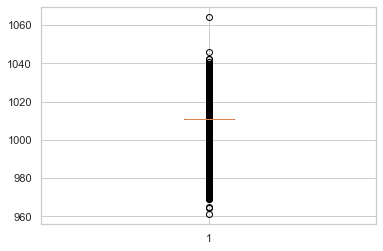

In [82]:
df_clean_slp_filter = df_clean.filter(df_clean.SLP < 4000).toPandas()
dewp_median = df_clean_slp_filter['SLP'].quantile(0.50)

# dewp_nine_five = df_clean_pd['DEWP'].quantile(0.95)
df_clean_pd['SLP'] = np.where(df_clean_pd['SLP'] > 4000, dewp_median, df_clean_pd['SLP'])
plt.boxplot(df_clean_pd["SLP"])
plt.show()



In [ ]:
double_cols = [x.name for x in df_clean.schema.fields if x.dataType == DoubleType()]
df_plot = df_clean.select(double_cols).toPandas()
Useful_Visualization_Functions.plotCorrelationMatrix1(df_plot)

In [ ]:
Useful_Visualization_Functions.plotScatter(df_plot, 'TEMP', 'DEWP', 'TEMP')

In [ ]:
Useful_Visualization_Functions.plotScatter(df_plot, 'TEMP', 'SLP', 'TEMP')

In [ ]:
Useful_Visualization_Functions.plotScatter(df_plot, 'TEMP', 'STP', 'STP')

In [ ]:
Useful_Visualization_Functions.plotScatter(df_plot, 'TEMP', 'VISIB', 'VISIB')

In [ ]:
Useful_Visualization_Functions.plotScatter(df_plot, 'TEMP', 'WDSP', 'WDSP')

In [ ]:
Useful_Visualization_Functions.plotScatter(df_plot, 'TEMP', 'MXSPD', 'MXSPD')

In [ ]:
Useful_Visualization_Functions.plotScatter(df_plot, 'TEMP', 'GUST', 'GUST')

In [56]:
df_clean = df_clean.filter(df_clean.DEWP < 100)
df_clean.count()
df_clean = df_clean.filter(df_clean.SLP < 4000)
df_clean.count()
df_clean = df_clean.filter(df_clean.STP < 100)
df_clean.count()
df_clean = df_clean.filter(df_clean.VISIB < 100)
df_clean.count()
df_clean = df_clean.filter(df_clean.WDSP < 100)
df_clean.count()
df_clean = df_clean.filter(df_clean.MXSPD < 100)
df_clean.count()
df_clean = df_clean.filter(df_clean.GUST < 200)
df_clean.count()

1940

In [ ]:
df_clean.select().show(200)